In [1]:
import pandas as pd

In [7]:
df = pd.read_csv('../data/filtered_data/preprocessed_data_openpath_prod_uprm_nicr.csv')

In [8]:
df.shape

(1001, 52)

In [11]:
(df.section_mode_argmax.value_counts() < 2).any()

True

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.special import kl_div
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
data = pd.read_csv('../data/ReplacedMode_Fix_02142024.csv')
data.drop_duplicates(inplace=True)

# data.sample(data.shape[0], random_state=SEED).reset_index(drop=True, inplace=True)

/var/folders/4x/l9lw50rn7qvf79m01f21x70mlpd6gh/T/ipykernel_85321/3793645385.py:1: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/ReplacedMode_Fix_02142024.csv')


In [3]:
ideal_tr, ideal_te = train_test_split(data, test_size=0.2, stratify=data.target, shuffle=True)

In [4]:
print(f"Ideal KL: {kl_div(ideal_tr.target.value_counts(normalize=True), ideal_te.target.value_counts(normalize=True)).mean()}")

Ideal KL: 3.704099704742548e-08


In [5]:
2.5e-3

0.0025

In [6]:
def get_optimal_interuser_splits(data: pd.DataFrame, threshold=2.5e-3, maxiters=5000):
    
    ids = data.user_id.unique().tolist()

    best_kl = np.inf
    ix = 0
    best_train_ids = None

    try:
        while True:

            if ix == maxiters:
                break

            train_id, test_id = train_test_split(ids, test_size=0.2, shuffle=True)
            train = data.loc[data.user_id.isin(train_id), :]
            test = data.loc[data.user_id.isin(test_id), :]

            kl1 = kl_div(
                train.section_mode_argmax.value_counts(normalize=True), 
                test.section_mode_argmax.value_counts(normalize=True)
            ).mean()
            
            kl2 = kl_div(
                train.target.value_counts(normalize=True), 
                test.target.value_counts(normalize=True)
            ).mean()
                
            kl = kl1 + kl2    
            
            if kl < best_kl:
                best_kl = kl
                # No need to save test because test will be a complement of train.
                best_train_ids = train_id
                print(f'\t\t-> Best KL: {best_kl}')

            ix += 1

            if kl < threshold:
                break

    except KeyboardInterrupt:
        print("Stopped iterations. Best KL till now: ", best_kl)
   
    finally:
        return best_train_ids

In [7]:
best_train = get_optimal_interuser_splits(data)

		-> Best KL: 0.019654163171699848
		-> Best KL: 0.00698817617574597
		-> Best KL: 0.005533063761614154
		-> Best KL: 0.003655132674484631
		-> Best KL: 0.002547459671179468
		-> Best KL: 0.0022263571393444375


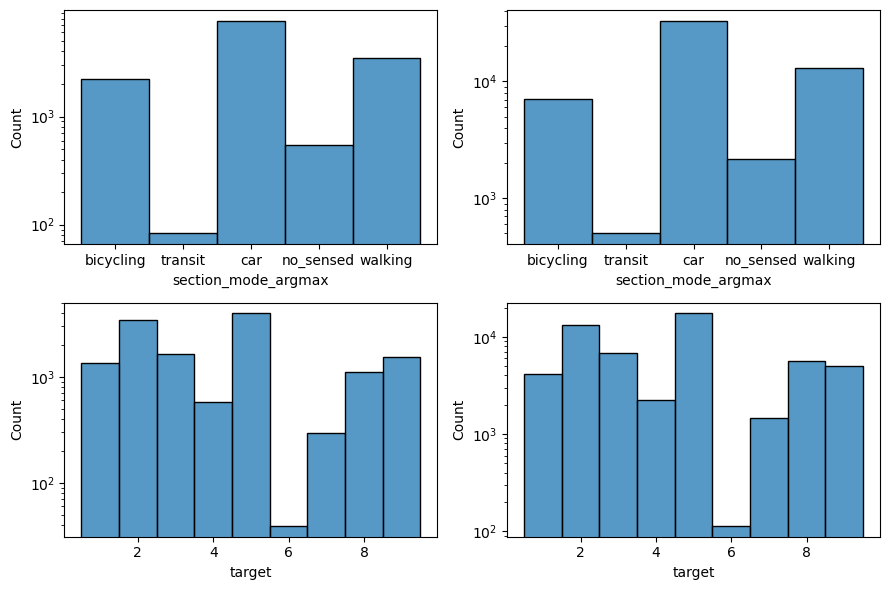

In [8]:
test_data = data.loc[data.user_id.isin(best_train), :]
train_data = data.loc[~data.user_id.isin(best_train), :]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 6))
sns.histplot(train_data.section_mode_argmax, ax=ax[0][0], discrete=True).set_yscale('log')
sns.histplot(test_data.section_mode_argmax, ax=ax[0][1], discrete=True).set_yscale('log')
sns.histplot(train_data.target, ax=ax[1][0], discrete=True).set_yscale('log')
sns.histplot(test_data.target, ax=ax[1][1], discrete=True).set_yscale('log')
fig.tight_layout()
plt.show()

In [9]:
print(best_train)

['7559c3f880f341e898a402eba96a855d', '1635c003b1f94a399ebebe21640ffced', '6656c04c6cba4c189fed805eaa529741', '4baf8c8af7b7445e9067854065e3e612', '42b3ee0bc02a481ab1a94644a8cd7a0d', 'f3a33641ffb6478f901350c55b6385f8', '14103cda12c94642974129989d39e50d', 'd7a732f4a8644bcbb8dedfc8be242fb2', '509b909390934e988eb120b58ed9bd8c', '3701bb586bf24d0caee8dd1d1421bb15', '802667b6371f45b29c7abb051244836a', 'd3dff742d07942ca805c2f72e49e12c5', 'feb6a3a8a2ef4f4a8754bd79f7154495', 'feb1d940cd3647d1a101580c2a3b3f8c', '90480ac60a3d475a88fbdab0a003dd5d', '3d981e617b304afab0f21ce8aa6c9786', 'c6e4db31c18b4355b02a7dd97deca70b', '8fdc9b926a674a9ea07d91df2c5e06f2', 'b41dd7d7c6d94fe6afe2fd26fa4ac0bd', 'e049a7b2a6cb44259f907abbb44c5abc', '3f7f2e536ba9481e92f8379b796ad1d0', '41c1182a404540a3820dff7de1c3d0e7', 'add706b73839413da13344c355dde0bb', 'fc51d1258e4649ecbfb0e6ecdaeca454', 'f446bf3102ff4bd99ea1c98f7d2f7af0', '840297ae39484e26bfebe83ee30c5b3e', 'dc1ed4d71e3645d0993885398d5628ca', 'ece8b0a509534e98a0d369f25d

In [27]:
counts = data.groupby('user_id').size()
filtered = counts[counts >= 5]

In [3]:
from sklearn.ensemble import RandomForestClassifier

params = {
    'ccp_alpha': 0.0031503743500287396,
    'max_depth': int(5.879792418246912 * 10), 
    'max_features': 0.16332372250446126, 
    'min_samples_leaf': int(1.7742589153489061 * 10), 
    'min_samples_split': int(2.391021401374942 * 10), 
    'n_estimators': int(100 * 0.5038646539940661)
}

clf = RandomForestClassifier(**params)

In [7]:
data.drop(columns=[
    'source',
     'end_ts',
     'end_fmt_time',
     'end_loc',
     'raw_trip',
     'start_ts',
     'start_fmt_time',
     'start_loc',
     'duration',
     'distance',
     'start_place',
     'end_place',
     'cleaned_trip',
     'inferred_labels',
     'inferred_trip',
     'expectation',
     'confidence_threshold',
     'expected_trip',
     'user_input',
     'start:year',
     'start:month',
     'start:day',
     'start:hour',
     'start_local_dt_minute',
     'start_local_dt_second',
     'start_local_dt_weekday',
     'start_local_dt_timezone',
     'end:year',
     'end:month',
     'end:day',
     'end:hour',
     'end_local_dt_minute',
     'end_local_dt_second',
     'end_local_dt_weekday',
     'end_local_dt_timezone',
     '_id',
     'user_id',
     'metadata_write_ts',
     'additions',
     'mode_confirm',
     'purpose_confirm',
     'distance_miles',
     'Mode_confirm',
     'Trip_purpose',
     'original_user_id',
     'program',
     'opcode',
     'Timestamp',
     'birth_year',
     'primary_job_commute_time',
     'income_category',
     'n_residence_members',
     'n_residents_u18',
     'n_residents_with_license',
     'n_motor_vehicles',
     'available_modes',
     'age',
     'gender_Man',
     'gender_Man;Nonbinary/genderqueer/genderfluid',
     'gender_Nonbinary/genderqueer/genderfluid',
     'gender_Prefer not to say',
     'gender_Woman',
     'gender_Woman;Nonbinary/genderqueer/genderfluid',
     'has_drivers_license_No',
     'has_drivers_license_Prefer not to say',
     'has_drivers_license_Yes',
     'has_multiple_jobs_No',
     'has_multiple_jobs_Prefer not to say',
     'has_multiple_jobs_Yes',
     "highest_education_Bachelor's degree",
     'highest_education_Graduate degree or professional degree',
     'highest_education_High school graduate or GED',
     'highest_education_Less than a high school graduate',
     'highest_education_Prefer not to say',
     'highest_education_Some college or associates degree',
     'primary_job_type_Full-time',
     'primary_job_type_Part-time',
     'primary_job_type_Prefer not to say',
     'primary_job_description_Clerical or administrative support',
     'primary_job_description_Custodial',
     'primary_job_description_Education',
     'primary_job_description_Food service',
     'primary_job_description_Manufacturing, construction, maintenance, or farming',
     'primary_job_description_Medical/healthcare',
     'primary_job_description_Other',
     'primary_job_description_Professional, managerial, or technical',
     'primary_job_description_Sales or service',
     'primary_job_commute_mode_Active transport',
     'primary_job_commute_mode_Car transport',
     'primary_job_commute_mode_Hybrid',
     'primary_job_commute_mode_Public transport',
     'primary_job_commute_mode_Unknown',
     'primary_job_commute_mode_WFH',
     'is_overnight_trip',
     'n_working_residents',
     'start_lat',
     'start_lng',
     'end_lat',
     'end_lng',
     'temperature_2m (°F)',
     'relative_humidity_2m (%)',
     'dew_point_2m (°F)',
     'rain (inch)',
     'snowfall (inch)',
     'wind_speed_10m (mp/h)',
     'wind_gusts_10m (mp/h)',
     'section_distance_argmax',
     'section_duration_argmax',
     'section_mode_argmax',
     'section_coordinates_argmax',
     'mph',
     'target',
     'av_s_micro',
     'av_ridehail',
     'av_unknown',
     'av_car',
     'av_transit',
     'av_walk',
     'av_s_car',
     'av_no_trip',
     'av_p_micro',
     'cost_p_micro',
     'cost_no_trip',
     'cost_s_car',
     'cost_transit',
     'cost_car',
     'cost_s_micro',
     'cost_ridehail',
     'cost_walk',
     'cost_unknown'
])

['source',
 'end_ts',
 'end_fmt_time',
 'end_loc',
 'raw_trip',
 'start_ts',
 'start_fmt_time',
 'start_loc',
 'duration',
 'distance',
 'start_place',
 'end_place',
 'cleaned_trip',
 'inferred_labels',
 'inferred_trip',
 'expectation',
 'confidence_threshold',
 'expected_trip',
 'user_input',
 'start:year',
 'start:month',
 'start:day',
 'start:hour',
 'start_local_dt_minute',
 'start_local_dt_second',
 'start_local_dt_weekday',
 'start_local_dt_timezone',
 'end:year',
 'end:month',
 'end:day',
 'end:hour',
 'end_local_dt_minute',
 'end_local_dt_second',
 'end_local_dt_weekday',
 'end_local_dt_timezone',
 '_id',
 'user_id',
 'metadata_write_ts',
 'additions',
 'mode_confirm',
 'purpose_confirm',
 'distance_miles',
 'Mode_confirm',
 'Trip_purpose',
 'original_user_id',
 'program',
 'opcode',
 'Timestamp',
 'birth_year',
 'primary_job_commute_time',
 'income_category',
 'n_residence_members',
 'n_residents_u18',
 'n_residents_with_license',
 'n_motor_vehicles',
 'available_modes',
 'age

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold

cv = StratifiedGroupKFold(n_splits=2)

for tr_ix, te_ix in cv.split(data)

clf.fit()